In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision
import numpy as np
import cv2

from PIL import Image
from torch import nn

# Faster R-CNN
![](http://static.zybuluo.com/AustinMxnet/rcrfshe3jlo0a1idyukvu9qr/image.png)

Faster R-CNN将Fast R-CNN中的Selective Search换成了Region Proposal Network，这样位置网络就和分类网络结合起来，**于是CNN提取的特征feature maps被两者共用**，不仅极大加快了速度，还提升了精度（两者会互相促进）。

![](http://static.zybuluo.com/AustinMxnet/gshcyphq57nz40fs8gxqju56/image.png)

Faster R-CNN的训练过程：

1. 提取图片features
2. 创建目标anchors
3. RPN网络输出这些anchors的locations和objectness分数
4. 取locations和objectness分数最好的前N个anchors，又称为proposal layer
5. 将这N个anchors输入网络，取得更精确的locations得分和classification得分
6. 计算步骤3中的`rpn_cls_loss`和`rpn_reg_loss`
7. 精算步骤5中的`roi_cls_loss`和`roi_reg_loss`

## 1 Input
我们用PyTorch官方实现的Faster R-CNN网络来学习，论文中使用提取features的backbone网络是VGG，PyTorch优化使用了ResNet-50并结合了FPN，我们先看下第一层`transform`：

In [2]:
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model.eval()

list(model._modules.items())[0]

('transform',
 GeneralizedRCNNTransform(
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     Resize(min_size=(800,), max_size=1333, mode='bilinear')
 ))

可以看出先对数据做了归一化`Normalize`，然后调整图片大小（等比缩放），在保证最长边不超过`1333`情况下，最短边缩放到`800`：

In [3]:
def resize(image, min_size=800, max_size=1333):
    im_shape = torch.tensor(image.shape[-2:])
    min_s = float(torch.min(im_shape))
    max_s = float(torch.max(im_shape))
    scale_factor = min_size / min_s
    if max_s * scale_factor > max_size:
        scale_factor = max_size / max_s

    return(torch.nn.functional.interpolate(
        image[None], scale_factor=scale_factor, mode='bilinear', recompute_scale_factor=True,
        align_corners=False)[0])


image = torch.rand(3, 200, 300)  # get some dummy image
resize(image).shape

torch.Size([3, 800, 1200])

保证输入图片最长边不超过`1333`，避免内存爆炸：

In [4]:
image = torch.rand(3, 3000, 1300)  # get some dummy image
print(resize(image).shape)

del image, model

torch.Size([3, 1333, 577])


## 2 Feature Extraction
Faster R-CNN网络主要有三个部分，如下图所示，分别为`feature extraction`、`region proposal`和`predication`：

![](http://static.zybuluo.com/AustinMxnet/qw6exo53ufnppmtyfg1lyodu/image.png)

### 2.1 FPN
注意上图论文中的`feature extraction`使用的backbone是VGG，PyTorch官方版本使用了带FPN的ResNet-50。如下图所示，ResNet-50四个阶段的features都被使用了。低层的特征语义信息比较少，但是目标位置准确；高层的特征语义信息比较丰富，但是目标位置比较粗略。将低层的特征和高层的特征融合起来，有利于网络性能。另外目标框会随着features减小而减小，这样在被缩小了32倍的最后一层features上，小目标就会变得非常小，难以被检测出来，**于是融合后不同尺度的特征负责检测不同大小的物体**

![](http://static.zybuluo.com/AustinMxnet/thekkuvtlvdtvyeikrpz60gf/image.png)

如图所示，高层的特征会被放大2倍后，加上经过1x1卷积的底层特征，下面是结合了FPN的ResNet-50的输出：

In [5]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
backbone = resnet_fpn_backbone('resnet50', pretrained=False)

x = torch.rand(1, 3, 800, 800)  # get some dummy image
output = backbone(x)
for k, v in output.items():
    print('features', k, v.shape)
    
del x, output, backbone

features 0 torch.Size([1, 256, 200, 200])
features 1 torch.Size([1, 256, 100, 100])
features 2 torch.Size([1, 256, 50, 50])
features 3 torch.Size([1, 256, 25, 25])
features pool torch.Size([1, 256, 13, 13])


`features 0/1/2/3`分别对应图中的`P2/3/4/5`，接下来就需要在这些features上预测原图中的物体。

## 3 Region Proposal Network
![](http://static.zybuluo.com/AustinMxnet/golbh698jmwkjro1lo3dmx3t/image.png)

如上图所示，假设backbone的`stride=4`或者说原图Image被down sample了4倍，由于多次卷积操作，`feature_map`中一个cell的感受野要远大于左边的一个grid，甚至能达到整幅图的区域。上文中带FPN的ResNet-50提供了4种尺寸的feature maps，我们可以用这些feature maps中的cells来预测原图中的物体。

### 3.1 Anchors
因为物体的形状和大小各种各样，所以一个cell需要能够预测形状和大小不同的物体（物体中心靠近cell中心）。如果直接让网络学习各种不确定的目标框会很难，所以我们对这些cells预先设置了一些anchors，让cells基于这些anchors预测大小和位置的偏移量。

设anchors的大小为$s$，宽高比为$r>0$，那么anchors的宽和高分别为$s/\sqrt{r}$和$s\sqrt{r}$。如果$r$有3种，$s$有2种，那么组合起来能得到6种框：

In [6]:
ratio = [0.5, 1, 2]
scale = [16., 32.]

# [width, height]
anchors = [[s*np.sqrt(1/r), s*np.sqrt(r)] for s in scale
                                          for r in ratio]

np.around(anchors, 2)

array([[22.63, 11.31],
       [16.  , 16.  ],
       [11.31, 22.63],
       [45.25, 22.63],
       [32.  , 32.  ],
       [22.63, 45.25]])

假设图像大小为$64\times 64$，我们看下上面6种anchors画在中心的样子：

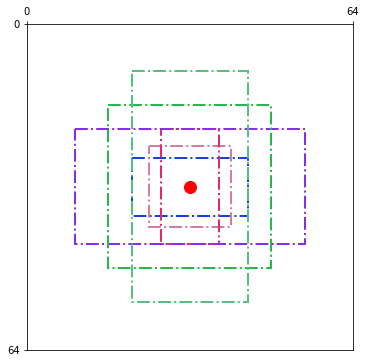

In [7]:
from matplotlib.patches import Rectangle


def plot_init_grid(ax, w=416, h=416, grid=13):
    ax.set_xticks(np.arange(0, w+1, w/grid))
    ax.set_yticks(np.arange(0, h+1, h/grid))
    ax.xaxis.tick_top()
    ax.set_aspect('equal')
    plt.xlim([0, w])
    plt.ylim([0, h])
    ax.invert_yaxis()


def plot_anchors(cx, cy, anchors):
    for w, h in anchors:
        xy = (cx-w/2., cy-h/2.)
        rect = Rectangle(xy, w, h, linewidth=2, fill=False, linestyle='-.',
                         edgecolor=np.random.rand(3,))
        ax.add_patch(rect)


# 图片尺寸
img_w = 64
img_h = 64
cx = img_w / 2
cy = img_h / 2

plt.figure(figsize=(6, 6))
ax = plt.gca()
plot_init_grid(ax, img_w, img_h, grid=1)


plt.plot(cx, cy, '.r', markersize=24)
plot_anchors(cx, cy, anchors)
plt.show()

我们可以脑补一下feature maps的每个cell都有预先设定的anchors，于是Region Proposal Network（RPN）就要对这些anchors进行处理。

> - 训练时，凡是越过图片边界（cross the boundary of the image）的anchors都被忽略
> - 测试时，越过边界的anchors被截断在边界处

### 3.2 RPN
如下图所示，假设每个cell有$k$个anchors，于是RPN要判断这$k$个anchors否为物体（分类，classification layer），还要判断准确的位置和形状（回归，regression layer），在这之前先做一次3x3卷积得到channel数为256-d的featuer maps。

![](http://static.zybuluo.com/AustinMxnet/m5tols2gexri5cmlqnkywwsa/image.png)

RPN网络代码如下：

In [8]:
import torch.nn.functional as F

class RPNHead(nn.Module):
    """
    Adds a simple RPN Head with classification and regression heads

    Arguments:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
    """

    def __init__(self, in_channels, num_anchors):
        super(RPNHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels,
                              kernel_size=3, stride=1, padding=1)
        self.cls_logits = nn.Conv2d(in_channels, num_anchors, 
                                    kernel_size=1, stride=1)
        self.bbox_pred = nn.Conv2d(in_channels, num_anchors * 4, 
                                   kernel_size=1, stride=1)

        for layer in self.children():
            torch.nn.init.normal_(layer.weight, std=0.01)
            torch.nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        # type: (List[Tensor]) -> Tuple[List[Tensor], List[Tensor]]
        logits = []
        bbox_reg = []
        for feature in x:
            t = F.relu(self.conv(feature))
            logits.append(self.cls_logits(t))
            bbox_reg.append(self.bbox_pred(t))
        return logits, bbox_reg

由于FPN的backbone会输出多组feature maps（分别为`stride=4/8/16/32`），所以`RPNHead`的`forward()`默认输入`x`为iteratble类型的，例如`[fm_1/4, fm_1/8, fm_1/16, fm_1/32]`。整个过程如下图所示（设$k=3$）：

![](http://static.zybuluo.com/AustinMxnet/zrtax3k1fdob7k9t21gq9rxm/image.png)

需要注意的是，这里黄色`scores`的`channels=3`，而非$2k=10$，这是因为是判断框是否为物体的分类函数用了逻辑回归，直接输出的是logit而非概率，loss函数用了`binary_cross_entropy_with_logits`，应该是为了优化cross entropy和sigmoid的联合求导（类似softmax和corss entropy联合求导）。假设$w,h=32,c=10$，那么对应的代码为：

In [9]:
x = torch.rand(1, 10, 32, 32)
scores, coordinates = RPNHead(10, 3)([x])
print("scores:", scores[0].shape)
print("coordinates:", coordinates[0].shape)
del x, scores, coordinates

scores: torch.Size([1, 3, 32, 32])
coordinates: torch.Size([1, 12, 32, 32])


### 3.3 Bounding Box Regression
现在RPN预测的物体bounding box。如下图所示，$x_a, y_a, w_a, h_a$是某一个anchor，$x, y, w, h$是RPN基于这个anchor预测的bbox，$x^*, y^*, w^*, h^*$是对应目标的ground truth。

![](http://static.zybuluo.com/AustinMxnet/y51jfgzsytzd8xjidhp6ij7l/image.png)

那么将中心坐标偏移量和宽高比分别归一化后可以得到$t_x, t_y, t_w, t_h$，也就是RPN网络需要学习输出的bbox信息，而$t_*, t_*, t_*, t_*$是ground truth，两者结合可以计算出bounding box regreesion分支的loss。

$$t_{\mathrm{x}}=\left(x-x_{\mathrm{a}}\right) / w_{\mathrm{a}}, \quad t_{\mathrm{y}}=\left(y-y_{\mathrm{a}}\right) / h_{\mathrm{a}}$$

$$t_{\mathrm{w}}=\log \left(w / w_{\mathrm{a}}\right), \quad t_{\mathrm{h}}=\log \left(h / h_{\mathrm{a}}\right)$$

$$t_{\mathrm{x}}^{*}=\left(x^{*}-x_{\mathrm{a}}\right) / w_{\mathrm{a}}, \quad t_{\mathrm{y}}^{*}=\left(y^{*}-y_{\mathrm{a}}\right) / h_{\mathrm{a}}$$

$$t_{\mathrm{w}}^{*}=\log \left(w^{*} / w_{\mathrm{a}}\right), \quad t_{\mathrm{h}}^{*}=\log \left(h^{*} / h_{\mathrm{a}}\right)$$

分别除以$w_a, h_a$进行归一化利于网络学习，但是为什么宽高比值都加了一个log函数呢？**因为宽高比必须大于等于0，所以变成了一个带约束的优化问题，而$w/w_a=e^{t_w}$恒大于0，这样网络输出的$t_w, t_h$就没有限制了！！！**

### 3.4 Training RPN
anchors根据有无物体分为正样本和负样本：如果一个anchor和某一个gt框的IoU大于0.7就被认为是正样本，如果特殊情况下某个gt框没有任何一个anchor与之对应，就选IoU最高的那个anchor；凡是IoU小于0.3的都被认为是负样本。

尽管可以所有的正负样本都可以参与训练，但是因为图片中目标个数有限，所以会导致大多数anchors都是负样本（背景）。例如$k=9$，feature maps的 $w=h=50$时，anchors总数为$9\times 50 \times50=22500$个，这样正负样本很不平衡，于是作者在一张图中随机各选取128个正负样本组成256个anchors的mini batch。

RPN网络的Loss函数如下，$N_{reg}$只包括$p^*=1$的正样本：

$$L\left(\left\{p_{i}\right\},\left\{t_{i}\right\}\right)=\frac{1}{N_{c l s}} \sum_{i} L_{c l s}\left(p_{i}, p_{i}^{*}\right)+\lambda \frac{1}{N_{r e g}} \sum_{i} p_{i}^{*} L_{r e g}\left(t_{i}, t_{i}^{*}\right)$$

### 3.5 NMS
因为RPN输出的目标框会有很多重叠的（如下图所示），所以我们需要使用NMS进行过滤。

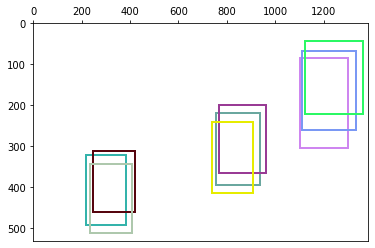

In [10]:
from matplotlib.patches import Rectangle


def plt_boxes(bboxes, ax):
    """ matplotlib Rectangle --- (xy, w, h)
    """
    for box in bboxes:
        x1, y1, x2, y2, _ = box
        w = x2 - x1
        h = y2 - y1
        ax.add_patch(Rectangle((x1, y1), w, h, linewidth=2, fill=False,
                               edgecolor=np.random.rand(3,)))
    plt.xlim([0, max(bboxes[:, 2])+20])
    plt.ylim([0, max(bboxes[:, 3])+20])
    ax.xaxis.tick_top()
    ax.invert_yaxis()


# [x1, y1, x2, y2, score]
dets = np.array([[218,  322, 385,  491, 0.98],
                 [247,  312, 419,  461, 0.83],
                 [237,  344, 407,  510, 0.92],
                 [757,  218, 937,  394, 0.96],
                 [768,  198, 962,  364, 0.85],
                 [740,  240, 906,  414, 0.83],
                 [1101, 84,  1302, 303, 0.82],
                 [1110, 67,  1331, 260, 0.97],
                 [1123, 42,  1362, 220, 0.85]])

ax = plt.gca()
plt_boxes(dets, ax)
plt.show()

首先按照分类得分高低将框排序，然后遍历（已删除的不再遍历），删除和当前框$\text{IoU}>\text{threshold}$（论文中为0.7）的框。

IoU的公式和示意图如下：

$$J(\mathcal{A}, \mathcal{B})=\frac{|\mathcal{A} \cap \mathcal{B}|}{|\mathcal{A} \cup \mathcal{B}|}$$

![](http://static.zybuluo.com/AustinMxnet/1qp8e6jjgogbpi7cvuoo14h9/image.png)

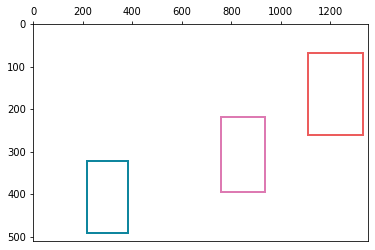

In [11]:
def nms(dets, thres):
    """
    @dets, detecion results, shape: [batch, 5], form: [[x1, y1, x2, y2, score]]
    @thres, threshold
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    kept_idx = []
    while order.size > 0:
        i = order[0]
        kept_idx.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2-xx1+1)
        h = np.maximum(0.0, yy2-yy1+1)

        inter = w * h
        IoU = inter / (area[i] + area[order[1:]] - inter)

        inds = np.where(IoU <= thres)[0]
        order = order[inds+1] # IoU starts from 1, so add 1 here to align the index

    return kept_idx

"""
[757, 218, 937, 394, 0.96]
[768, 198, 962, 364, 0.85]
[740, 240, 906, 414, 0.83]
"""
dets_nms = dets[nms(dets, 0.5)]
ax = plt.gca()
plt_boxes(dets_nms, ax)
plt.show()

del dets, dets_nms

### 3.6 RPN总结
RPN的训练过程如下：
1. 生成anchors，忽略越界的anchors
2. 为anchors分配gt框，IoU>0.7的为正样本，<0.3的为负样本，其他anchors忽略
3. 按1:1比例随机选取正负样本，生成容量为256的batch进行训练
4. 对所有样本进行region proposal，保留正样本（有物体）的regions
5. 对proposal regions进行NMS，每张图选取2000个proposal regions，送入Fast R-CNN网络

RPN的测试过程稍有不同：
1. 生成anchors，截断越界的anchors
2. 对所有anchors进行region proposal
3. 对proposal regions进行NMS，每张图选取300个proposal regions，送入Fast R-CNN网络

## 4 Fast R-CNN

有了RPN输出的proposal regions，Fast R-CNN网络对这些regions进一步精炼，并且判断region的是哪一类物体。由于backbone提取的特征可以被RPN和Fast R-CNN共享，所以要将对应proposal regions的features提取出来（见“Feature Extraction”小节）。为了保证输入Fast R-CNN的feature maps大小一致（e.g.，$7x7$），需要用到ROI Pooling。

### 4.1 ROI Pooling
如下图所示，候选框$r_0$和$r_1$形状不同，但是都要pooling到$2\times2$，而且两者还有个overlap的$x_{23}$，所以$x_{23}$上的梯度要累加。

![](http://static.zybuluo.com/AustinMxnet/as2ru4a8hzjird3p9odb5e4j/image.png)

如下图所示，假设一个$8\times8$的feature map，其`stride=32`，其中一个proposal region在原图（256x256）中大小为230x160并且起点为原点（左下角），现在需要对这个框对应的RoI feature进行pooling得到$2\times2$的输出：

1. 计算这个框在feature map上对应的RoI位置，其右上角位置为(230/32=7.18, 160/32=5)，第一次量化操作得到(7, 5)；
2. 将对应的featurer RoI划分为$2\times2 = 4$个区域，每一个大小为(7/2=3.5, 5/2=2.5)，第二次量化得到(3, 2)、(4, 2)、(3, 3)、(3, 2)共4个区域的大小；
3. 在4个区域内做pooling操作，一般为max pooling；

因为RoI Pooling的过程存在两次量化取整操作，会导致误差累积，所以后来出现了避免两次量化误差的RoI Align和积分形式的Precision RoI等Pooling方法。

![](http://static.zybuluo.com/AustinMxnet/5wo1q5iih30vsbk29limtv90/image.png)

反向传播公式为：

$$\frac{\partial L}{\partial x_{i}}=\sum_{r} \sum_{j}\left[i=i^{*}(r, j)\right] \frac{\partial L}{\partial y_{r j}}$$

这里，$x_i$代表池化前特征图上的像素点；$y_{rj}$代表池化后的第$r$个候选区域的第$j$个点；$i^* (r,j)$代表点$y_{rj}$的来源，即最大池化时选出的最大像素值所在点的坐标。由上式可以看出，只有当池化后某一个点的像素值在池化过程中采用了当前点$x_i$的像素值（即满足$i=i^* (r,j)$，才在$x_i$代表处回传梯度。

### 4.2 Prediction
Fast R-CNN需要预测proposal regions的类别，并且进一步修正这些regions的位置和大小。先将RoI Pooling/Align得到的7x7特征经过两个全连接层，然后预测`cls_score`和`bbox_pred`，如下图所示（图中将features的channels简化为1，实际应该等于backbone的features的channels）：

![](http://static.zybuluo.com/AustinMxnet/5kxs4lhbnyh8z9tnrefz5ae5/image.png)

In [12]:
class TwoMLPHead(nn.Module):
    def __init__(self, in_channels, representation_size):
        super(TwoMLPHead, self).__init__()
        self.fc6 = nn.Linear(in_channels, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        return x


class FastRCNNPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

In [13]:
num_classes = 10+1 # 1 is background
channels = 10

x = torch.rand(1, channels, 7, 7)
x_fc7 = TwoMLPHead(channels*7**2, 1024)(x)
cls, bbox = FastRCNNPredictor(1024, num_classes)(x_fc7)
print(cls.shape, bbox.shape)

del x, x_fc7, cls, bbox

torch.Size([1, 11]) torch.Size([1, 44])


最后的输出为每一类（包括背景）都预测了bbox，所以需要根据cls最高的那一类去取对应的bbox（其他bbox也不参与loss计算）。我觉得输出一个box就好了，网络更简单，也利于网络学习，但是我未验证过。

## 5 4-Step Alternating Training
论文中说RPN网络和Fast R-CNN网络不能联合训练，因为ROI Pooling对位置和特征不可同时求梯度（ROI Pooling的输入是特征和**基于同样特征预测的位置**），但是RoI Warp Pooling就可以，这点我没想明白。

作者推荐了一个4步训练法，流程如下：

![](http://static.zybuluo.com/AustinMxnet/jqchbox6jcpi0kqmx8fzqkkm/image.png)

最后附上一张我觉得最能体现整个训练和测试过程的图：

![](http://static.zybuluo.com/AustinMxnet/7jjjmmx9md96olys5a0gjj3a/image.png)

## 6 Inference (Test)
用官方预训练好的模型：

In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [15]:
# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's 
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class
  


def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

/home/austin/anaconda3/envs/gluon/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


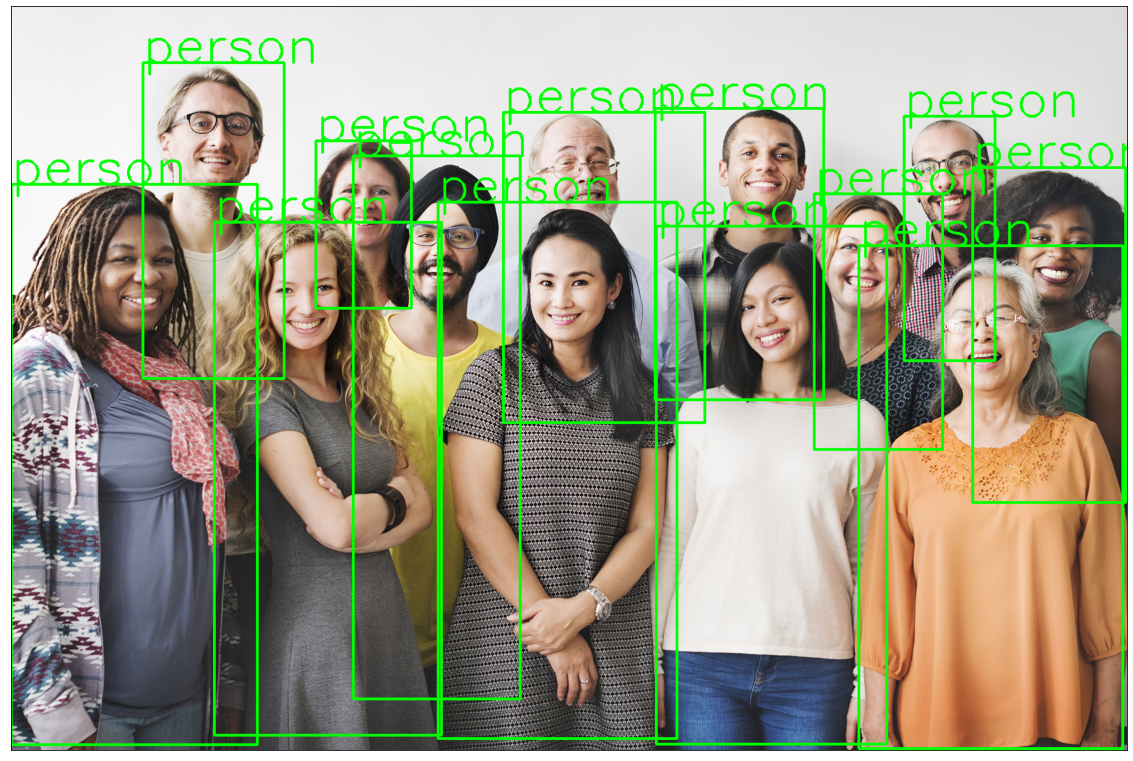

In [16]:
object_detection_api("../_files/people.jpg", threshold=0.8)

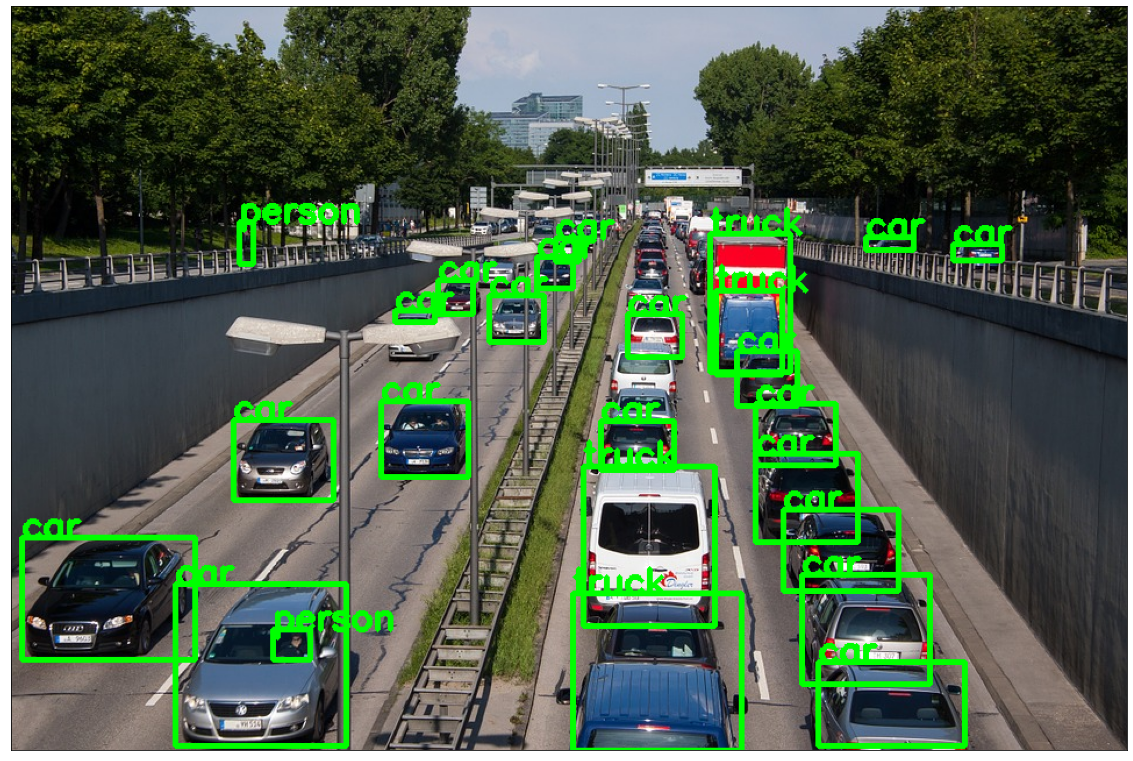

In [17]:
object_detection_api('../_files/traffic-143391_960_720.jpg', threshold=0.8, text_size=1)

## 7 推荐阅读
- [Faster R-CNN Object Detection with PyTorch](https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/)
- [捋一捋pytorch官方FasterRCNN代码](https://zhuanlan.zhihu.com/p/145842317)
- [一文读懂Faster RCNN](https://zhuanlan.zhihu.com/p/31426458)
- [Guide to build Faster RCNN in PyTorch](https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439)